In [ ]:
%%capture

!pip install swig
!pip install gymnasium
!pip install gymnasium[box2d]
!pip install stable_baselines3

## Importação de bibliotecas

Primeiro, importamos todas as bibliotecas necessárias. Isso inclui `gymnasium` para o ambiente de simulação, `matplotlib.pyplot` para visualização, `stable_baselines3` para o algoritmo de aprendizado por reforço, e `BaseCallback` para personalização do processo de treinamento.

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

## Definição de Callback Personalizado

Aqui, definimos um `CustomCallback` para registrar informações relevantes durante o treinamento, como recompensas acumuladas. Isso nos permite observar o desempenho do modelo ao longo do tempo.

In [ ]:
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

class CustomCallback(BaseCallback):
    """
    Callback personalizado para registrar o progresso do treinamento com mais detalhes,
    incluindo estatísticas como média, mínimo, máximo e desvio padrão das recompensas.

    Atributos:
        verbose (int): Nível de verbosidade.
        interval (int): Número de passos entre cada registro.
        total_rewards (float): Total de recompensas acumuladas no intervalo atual.
        rewards_stats (list of dicts): Lista para armazenar as estatísticas das recompensas.
    """

    def __init__(self, interval: int = 1000, verbose: int = 0):
        super().__init__(verbose)
        self.interval = interval
        self.next_time = interval
        self.total_rewards = []
        self.rewards_stats = []

    def _on_step(self) -> bool:
        reward = sum(self.locals["rewards"])
        self.total_rewards.append(reward)

        if self.num_timesteps >= self.next_time:
            self.next_time += self.interval
            avg_reward = np.mean(self.total_rewards)
            min_reward = np.min(self.total_rewards)
            max_reward = np.max(self.total_rewards)
            std_reward = np.std(self.total_rewards)
            self.rewards_stats.append({
                'avg': avg_reward,
                'min': min_reward,
                'max': max_reward,
                'std': std_reward
            })
            self.total_rewards.clear()  # Reset para o próximo intervalo
        return True

    def get_rewards_stats(self):
        """
        Retorna as estatísticas das recompensas registradas durante o treinamento.

        Retorna:
            list of dicts: Cada dicionário contém 'avg', 'min', 'max' e 'std' das recompensas
                           para cada intervalo registrado.
        """
        return self.rewards_stats

## Inicialização do ambiente

O ambiente é selecionado e inicializado. Isso define o contexto em que nosso agente operará.

In [ ]:
env = gym.make('CarRacing-v2')

## Configuração do treinamento do modelo

Configuramos o modelo PPO com o ambiente, definimos parâmetros como taxa de aprendizado e tamanho do lote, e iniciamos o treinamento com nosso callback personalizado.

In [ ]:
model = PPO(
    "CnnPolicy",
    env,
    learning_rate=1e-3,
    batch_size=128,
    verbose=1
)

callback = CustomCallback()

model.learn(total_timesteps=500000, callback=callback)

A saída de streaming foi truncada nas últimas 5000 linhas.
|    loss                 | 0.00918    |
|    n_updates            | 170        |
|    policy_gradient_loss | -0.0317    |
|    std                  | 0.758      |
|    value_loss           | 0.727      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -24.9       |
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 19          |
|    time_elapsed         | 1462        |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.058070645 |
|    clip_fraction        | 0.408       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.4        |
|    explained_variance   | 0.927       |
|    learning_rate        | 0.001       |
|    loss              

## Visualização de resultados

Após o treinamento, plotamos o progresso do treinamento usando matplotlib. Isso nos permite visualizar a melhoria no desempenho do modelo ao longo do tempo.

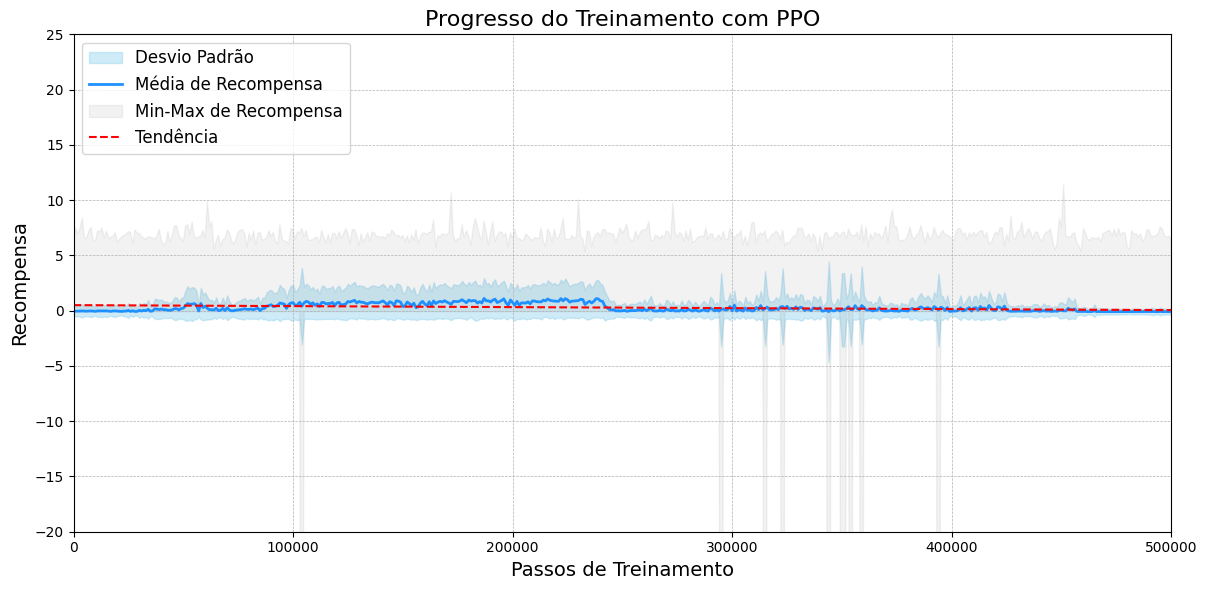

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Supondo que callback.rewards_stats contenha as estatísticas de recompensa aprimoradas
rewards_stats = callback.get_rewards_stats()



# Preparando dados para plotagem
steps = np.arange(len(rewards_stats)) * callback.interval
avg_rewards = [stat['avg'] for stat in rewards_stats]
min_rewards = [stat['min'] for stat in rewards_stats]
max_rewards = [stat['max'] for stat in rewards_stats]
std_rewards = [stat['std'] for stat in rewards_stats]

plt.figure(figsize=(12, 6))

# Recompensas médias com preenchimento de desvio padrão
plt.fill_between(steps, np.subtract(avg_rewards, std_rewards), np.add(avg_rewards, std_rewards), color='skyblue', alpha=0.4, label='Desvio Padrão')
plt.plot(steps, avg_rewards, label='Média de Recompensa', color='dodgerblue', linewidth=2)

# Área entre recompensas mínimas e máximas
plt.fill_between(steps, min_rewards, max_rewards, color='grey', alpha=0.1, label='Min-Max de Recompensa')

# Linha de tendência suavizada usando uma média móvel ou um polinômio de maior grau
trend_poly = np.polyfit(steps, np.poly1d(z)(steps), 3)
trendline = np.poly1d(trend_poly)
plt.plot(steps, trendline(steps), 'r--', label='Tendência')

# Ajustes finais de visualização
plt.xlabel('Passos de Treinamento', fontsize=14)
plt.ylabel('Recompensa', fontsize=14)
plt.title('Progresso do Treinamento com PPO', fontsize=16)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.ylim([-20, 25])
plt.xlim([0, 500000])

plt.show()
